In [1]:
import arviz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# select state
state = 'SP'
# select confidence
confidence = 95

### Get the traces and posterior prediction

In [3]:
# Load the trace from a NetCDF file
trace = arviz.from_netcdf("trace.nc")

# Load the posterior predictive check
ppc = arviz.from_netcdf("ppc.nc")

### Get incidence data

In [4]:

# Incidence data
# ~~~~~~~~~~~~~~

# Fetch incidence data
df = pd.read_csv('../../interim/DENV_datasus/DENV-serotypes_1996-2025_monthly.csv', parse_dates=['date'])

# 1. Check if all columns are present
sero_cols = ["DENV_1", "DENV_2", "DENV_3", "DENV_4"]
required_cols = ["UF", "date", "DENV_total"] + sero_cols
assert all(col in df.columns for col in required_cols)

# 2. Sort for safety
df = df.sort_values(["date", "UF"]).reset_index(drop=True)
from datetime import datetime

df = df[df['date'] > datetime(1999,1,1)]

# 3. Factorize states and time
df["state_idx"], _ = pd.factorize(df["UF"])
df["month_idx"], _ = pd.factorize(df["date"])

# 4. Fill NaNs in a principled way
def fill_serotypes(row):
    sero = row[sero_cols]
    if sero.notna().any():
        # If at least one serotype is observed, treat missing ones as 0
        for col in sero_cols:
            if pd.isna(row[col]):
                row[col] = 0.0
    return row
df = df.apply(fill_serotypes, axis=1)

# 5. Compute N_typed
df["N_typed"] = df[sero_cols].sum(axis=1, skipna=False)                                         # if serotypes available --> sum them
df.loc[df[['DENV_1', 'DENV_2', 'DENV_3', 'DENV_4']].isna().all(axis=1), 'N_typed'] = np.nan      # if all serotypes are Nan --> N_typed = 0 --> Wait, I don't think this is appropriate.

# 6. Compute delta (typing fraction)
df["delta"] = df["N_typed"] / df["DENV_total"]
df['delta'] = df['delta'].where(df['N_typed'] > 0, np.nan) # When N_typed == 0, we don't know delta — mark as missing
df["delta"] = df["delta"].clip(lower=1e-12, upper=1 - 1e-12)

# 7. Compute year index
df["year"] = pd.to_datetime(df["date"]).dt.year
df["year_idx"] = df["year"] - df["year"].min()

# 8. Compute year-state index
df["state_year_idx"] = df["state_idx"].astype(str) + "_" + df["year_idx"].astype(str)
df["state_year_idx"], state_year_labels = pd.factorize(df["state_year_idx"])

# 9. Add year-region index
# df['region'] = df['UF'].map(uf2region_map)
# df["region_idx"], region_labels = pd.factorize(df["region"])
# df["region_year_idx"] = df["region_idx"].astype(str) + "_" + df["year_idx"].astype(str)
# df["region_year_idx"], region_year_labels = pd.factorize(df["region_year_idx"])

# 10. Build PyMC arrays

# --- For Beta model (typing fraction, always available) ---
delta_obs = df["delta"].to_numpy().astype(float)
N_total = df["DENV_total"].to_numpy().astype(int)

# --- For Multinomial model (subtypes, only when typed) ---
Y_multinomial = df[sero_cols].to_numpy().astype(int)
N_typed = df["N_typed"].to_numpy().astype(int)

# # --- Indices ---
# state_idx = df["state_idx"].to_numpy().astype(int)
# region_idx = df['region_idx'].to_numpy().astype(int)
# month_idx = df["month_idx"].to_numpy().astype(int)
# year_idx = df["year_idx"].to_numpy().astype(int)
# state_year_idx = df["state_year_idx"].to_numpy().astype(int)
# region_year_idx = df["region_year_idx"].to_numpy().astype(int)

/var/folders/ny/j5ym9thj7l34rykpfr__k_540000gr/T/ipykernel_4614/3983961415.py:60: RuntimeWarning: invalid value encountered in cast
  N_total = df["DENV_total"].to_numpy().astype(int)
/var/folders/ny/j5ym9thj7l34rykpfr__k_540000gr/T/ipykernel_4614/3983961415.py:63: RuntimeWarning: invalid value encountered in cast
  Y_multinomial = df[sero_cols].to_numpy().astype(int)
/var/folders/ny/j5ym9thj7l34rykpfr__k_540000gr/T/ipykernel_4614/3983961415.py:64: RuntimeWarning: invalid value encountered in cast
  N_typed = df["N_typed"].to_numpy().astype(int)


### Get the output to a .csv for further use

In [5]:
output = df[['date', 'UF', 'DENV_1', 'DENV_2', 'DENV_3', 'DENV_4', 'DENV_total']]
output[['p_1', 'p_2', 'p_3', 'p_4']] = trace['posterior']['p'].mean(dim=['chain','draw']).values
output.to_csv('../../interim/imputed_DENV_datasus/DENV-serotypes-imputed_1996-2025_monthly.csv')

/var/folders/ny/j5ym9thj7l34rykpfr__k_540000gr/T/ipykernel_4614/2693714004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output[['p_1', 'p_2', 'p_3', 'p_4']] = trace['posterior']['p'].mean(dim=['chain','draw']).values
/var/folders/ny/j5ym9thj7l34rykpfr__k_540000gr/T/ipykernel_4614/2693714004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output[['p_1', 'p_2', 'p_3', 'p_4']] = trace['posterior']['p'].mean(dim=['chain','draw']).values
/var/folders/ny/j5ym9thj7l34rykpfr__k_540000gr/T/ipykernel_4614/

### Visualise Y_obs (model vs. data)

/var/folders/ny/j5ym9thj7l34rykpfr__k_540000gr/T/ipykernel_4614/1897364164.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_obs_model_median[['DENV_1', 'DENV_2', 'DENV_3', 'DENV_4']] = ppc['posterior_predictive']['Y_obs'].median(dim=['chain','draw']).values
/var/folders/ny/j5ym9thj7l34rykpfr__k_540000gr/T/ipykernel_4614/1897364164.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_obs_model_median[['DENV_1', 'DENV_2', 'DENV_3', 'DENV_4']] = ppc['posterior_predictive']['Y_obs'].median(dim=['chain','d

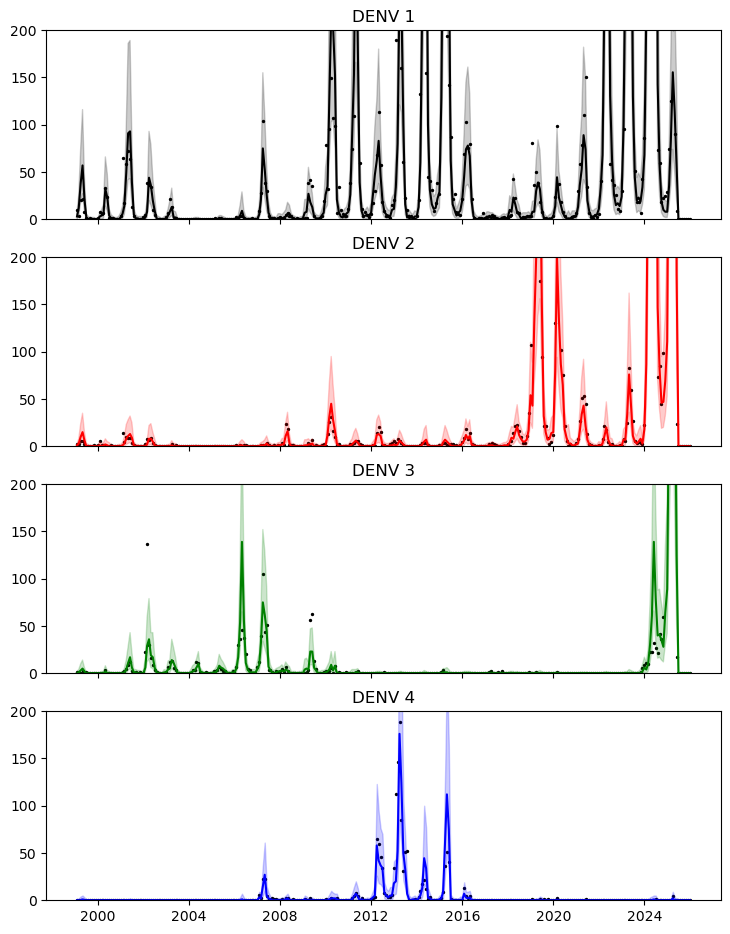

In [6]:
# Get serotyped cases from model (median)
Y_obs_model_median = df[['UF','date']]
Y_obs_model_median[['DENV_1', 'DENV_2', 'DENV_3', 'DENV_4']] = ppc['posterior_predictive']['Y_obs'].median(dim=['chain','draw']).values
Y_obs_model_median = Y_obs_model_median.set_index(['UF','date'])

# Get serotyped cases from model (lower)
Y_obs_model_lower = df[['UF','date']]
Y_obs_model_lower[['DENV_1', 'DENV_2', 'DENV_3', 'DENV_4']] = ppc['posterior_predictive']['Y_obs'].quantile(dim=['chain','draw'], q=(100-confidence)/2/100).values
Y_obs_model_lower = Y_obs_model_lower.set_index(['UF','date'])

# Get serotyped cases from model (lower)
Y_obs_model_upper = df[['UF','date']]
Y_obs_model_upper[['DENV_1', 'DENV_2', 'DENV_3', 'DENV_4']] = ppc['posterior_predictive']['Y_obs'].quantile(dim=['chain','draw'], q=1-(100-confidence)/2/100).values
Y_obs_model_upper = Y_obs_model_upper.set_index(['UF','date'])

# Get serotyped cases from model
Y_obs = df[['UF','date']]
Y_obs[['DENV_1', 'DENV_2', 'DENV_3', 'DENV_4']] = ppc['observed_data']['Y_obs'].values
Y_obs = Y_obs.set_index(['UF','date'])

# Get timepoints
time = df['date'].unique()

# Visualise
fig,ax=plt.subplots(nrows=4, figsize=(8.7, 11.3), sharex=True)
# data Y_obs
ax[0].scatter(time, Y_obs.loc[(state, slice(None)), 'DENV_1'].values, marker='o', s=2, color='black')
ax[1].scatter(time, Y_obs.loc[(state, slice(None)), 'DENV_2'].values, marker='o', s=2, color='black')
ax[2].scatter(time, Y_obs.loc[(state, slice(None)), 'DENV_3'].values, marker='o', s=2, color='black')
ax[3].scatter(time, Y_obs.loc[(state, slice(None)), 'DENV_4'].values, marker='o', s=2, color='black')
# model Y_obs (median)
ax[0].plot(time, Y_obs_model_median.loc[(state, slice(None)), 'DENV_1'].values, color='black')
ax[1].plot(time, Y_obs_model_median.loc[(state, slice(None)), 'DENV_2'].values, color='red')
ax[2].plot(time, Y_obs_model_median.loc[(state, slice(None)), 'DENV_3'].values, color='green')
ax[3].plot(time, Y_obs_model_median.loc[(state, slice(None)), 'DENV_4'].values, color='blue')
# model Y_obs (confidence)
ax[0].fill_between(time, Y_obs_model_lower.loc[(state, slice(None)), 'DENV_1'].values, Y_obs_model_upper.loc[(state, slice(None)), 'DENV_1'].values, color='black', alpha=0.2)
ax[1].fill_between(time, Y_obs_model_lower.loc[(state, slice(None)), 'DENV_2'].values, Y_obs_model_upper.loc[(state, slice(None)), 'DENV_2'].values, color='red', alpha=0.2)
ax[2].fill_between(time, Y_obs_model_lower.loc[(state, slice(None)), 'DENV_3'].values, Y_obs_model_upper.loc[(state, slice(None)), 'DENV_3'].values, color='green', alpha=0.2)
ax[3].fill_between(time, Y_obs_model_lower.loc[(state, slice(None)), 'DENV_4'].values, Y_obs_model_upper.loc[(state, slice(None)), 'DENV_4'].values, color='blue', alpha=0.2)
# titles
ax[0].set_title('DENV 1')
ax[1].set_title('DENV 2')
ax[2].set_title('DENV 3')
ax[3].set_title('DENV 4')
ax[0].set_ylim([0,200])
ax[1].set_ylim([0,200])
ax[2].set_ylim([0,200])
ax[3].set_ylim([0,200])
plt.savefig(f'{state}_observed_serotype_counts.png')
plt.show()
plt.close()


### Visualise the total number of serotyped cases and modeled serotype fractions

In [7]:
# Compute observed ratios
Y_obs['p_1'] = Y_obs['DENV_1']/(Y_obs['DENV_1'] + Y_obs['DENV_2'] + Y_obs['DENV_3'] + Y_obs['DENV_4'])
Y_obs['p_2'] = Y_obs['DENV_2']/(Y_obs['DENV_1'] + Y_obs['DENV_2'] + Y_obs['DENV_3'] + Y_obs['DENV_4'])
Y_obs['p_3'] = Y_obs['DENV_3']/(Y_obs['DENV_1'] + Y_obs['DENV_2'] + Y_obs['DENV_3'] + Y_obs['DENV_4'])
Y_obs['p_4'] = Y_obs['DENV_4']/(Y_obs['DENV_1'] + Y_obs['DENV_2'] + Y_obs['DENV_3'] + Y_obs['DENV_4'])

# Get total typed cases from model and data
N_typed = df[['UF','date']]
N_typed['N_typed_median'] = ppc['posterior_predictive']['N_typed_latent'].median(dim=['chain','draw']).values
N_typed['N_typed_lower'] = ppc['posterior_predictive']['N_typed_latent'].quantile(dim=['chain','draw'], q=(100-confidence)/2/100).values
N_typed['N_typed_upper'] = ppc['posterior_predictive']['N_typed_latent'].quantile(dim=['chain','draw'], q=1-(100-confidence)/2/100).values
N_typed['N_typed'] = ppc['observed_data']['N_typed_latent'].values
N_typed = N_typed.set_index(['UF','date'])

# Get serotype fractions
## Mean
p_mean = df[['UF','date']]
p_mean[['DENV_1', 'DENV_2', 'DENV_3', 'DENV_4']] = trace['posterior']['p'].mean(dim=['chain','draw']).values
p_mean = p_mean.set_index(['UF','date'])
## Lower
p_lower = df[['UF','date']]
p_lower[['DENV_1', 'DENV_2', 'DENV_3', 'DENV_4']] = trace['posterior']['p'].quantile(dim=['chain','draw'], q=(100-confidence)/2/100).values
p_lower = p_lower.set_index(['UF','date'])
## Upper
p_upper = df[['UF','date']]
p_upper[['DENV_1', 'DENV_2', 'DENV_3', 'DENV_4']] = trace['posterior']['p'].quantile(dim=['chain','draw'], q=1-(100-confidence)/2/100).values
p_upper = p_upper.set_index(['UF','date'])

# Get timepoints
time = df['date'].unique()

/var/folders/ny/j5ym9thj7l34rykpfr__k_540000gr/T/ipykernel_4614/3928856328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  N_typed['N_typed_median'] = ppc['posterior_predictive']['N_typed_latent'].median(dim=['chain','draw']).values
/var/folders/ny/j5ym9thj7l34rykpfr__k_540000gr/T/ipykernel_4614/3928856328.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  N_typed['N_typed_lower'] = ppc['posterior_predictive']['N_typed_latent'].quantile(dim=['chain','draw'], q=(100-confidence)/2/100).values
/var/folde

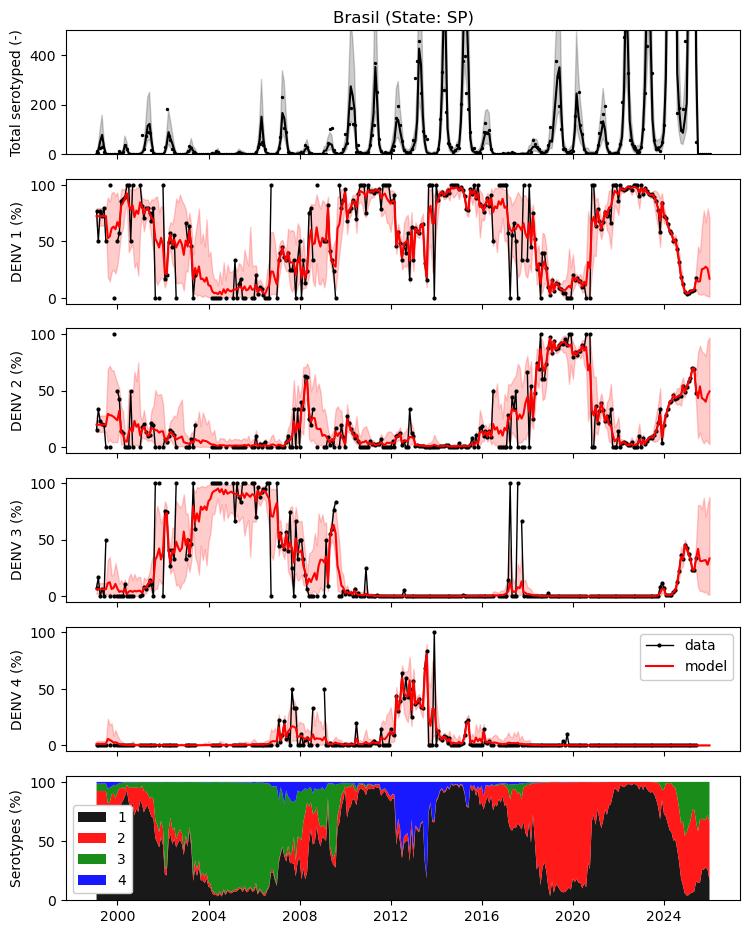

In [8]:
# Visualisation
fig,ax=plt.subplots(nrows=6, sharex=True, figsize=(8.7, 11.3))

# Step 1: total serotyped cases
ax[0].plot(time, N_typed.loc[(state, slice(None)), 'N_typed_median'].values, color='black')
ax[0].fill_between(time, N_typed.loc[(state, slice(None)), 'N_typed_lower'].values, N_typed.loc[(state, slice(None)), 'N_typed_upper'].values, color='black', alpha=0.2)
ax[0].scatter(time, N_typed.loc[(state, slice(None)), 'N_typed'].values, marker='o', s=2, color='black')
ax[0].set_ylim([0,500])
ax[0].set_ylabel('Total serotyped (-)')
ax[0].set_title(f'Brasil (State: {state})')

# Step 2: serotype fractions vs data
## DENV 1
ax[1].plot(time, Y_obs.loc[(state, slice(None)), 'p_1'].values*100, marker='o', markersize=2, linewidth=1, color='black')
ax[1].plot(time, p_mean.loc[state, 'DENV_1']*100, color='red')
ax[1].fill_between(time, p_lower.loc[state, 'DENV_1']*100, p_upper.loc[state, 'DENV_1']*100, alpha=0.2, color='red')
ax[1].set_ylabel('DENV 1 (%)')
## DENV 2
ax[2].plot(time, Y_obs.loc[(state, slice(None)), 'p_2'].values*100, marker='o', markersize=2, linewidth=1, color='black')
ax[2].plot(time, p_mean.loc[state, 'DENV_2']*100, color='red')
ax[2].fill_between(time, p_lower.loc[state, 'DENV_2']*100, p_upper.loc[state, 'DENV_2']*100, alpha=0.2, color='red')
ax[2].set_ylabel('DENV 2 (%)')
## DENV 3
ax[3].plot(time, Y_obs.loc[(state, slice(None)), 'p_3'].values*100, marker='o', markersize=2, linewidth=1, color='black')
ax[3].plot(time, p_mean.loc[state, 'DENV_3']*100, color='red')
ax[3].fill_between(time, p_lower.loc[state, 'DENV_3']*100, p_upper.loc[state, 'DENV_3']*100, alpha=0.2, color='red')
ax[3].set_ylabel('DENV 3 (%)')
## DENV 4
ax[4].plot(time, Y_obs.loc[(state, slice(None)), 'p_4'].values*100, marker='o', markersize=2, linewidth=1, color='black', label='data')
ax[4].plot(time, p_mean.loc[state, 'DENV_4']*100, color='red', label='model')
ax[4].fill_between(time, p_lower.loc[state, 'DENV_4']*100, p_upper.loc[state, 'DENV_4']*100, alpha=0.2, color='red')
ax[4].set_ylabel('DENV 4 (%)')
ax[4].legend(framealpha=1)

# Step 3: modeled serotype fractions
# Filter data for a single UF
df_star = p_mean.loc[state, ['DENV_1', 'DENV_2', 'DENV_3', 'DENV_4']]
# Plot manually
ax[5].stackplot(
    df_star.index, [df_star['DENV_1']*100, df_star['DENV_2']*100, df_star['DENV_3']*100, df_star['DENV_4']*100],
    labels=['1', '2', '3', '4'],
    colors=['black', 'red', 'green', 'blue'],
    alpha=0.9
)
ax[5].legend(framealpha=1)
ax[5].set_ylabel('Serotypes (%)')

plt.savefig(f'{state}_total_serotyped.pdf')
plt.show()
plt.close()

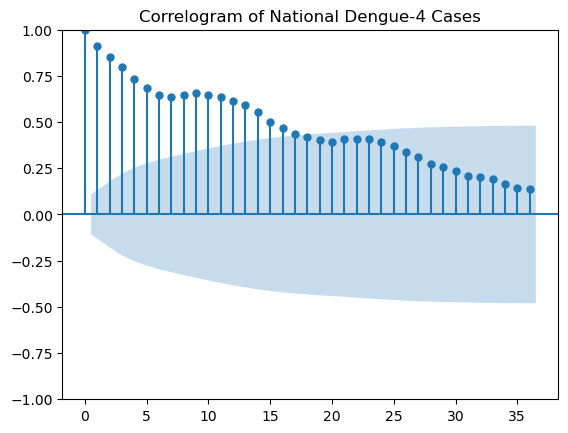

<Figure size 640x480 with 0 Axes>

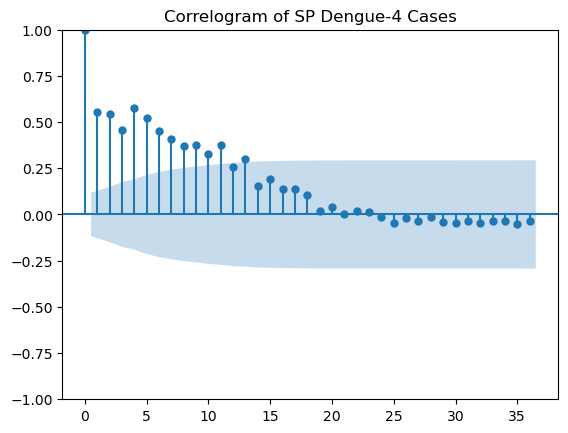

<Figure size 640x480 with 0 Axes>

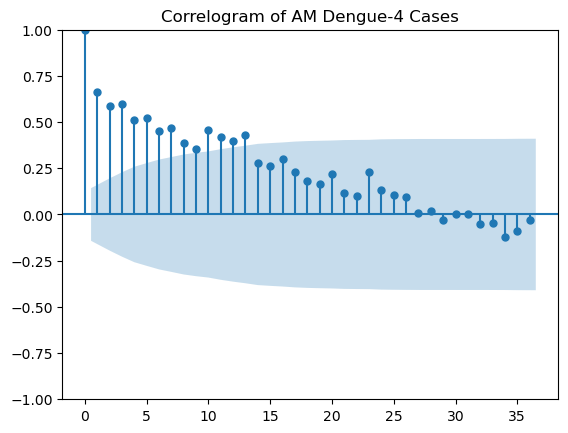

<Figure size 640x480 with 0 Axes>

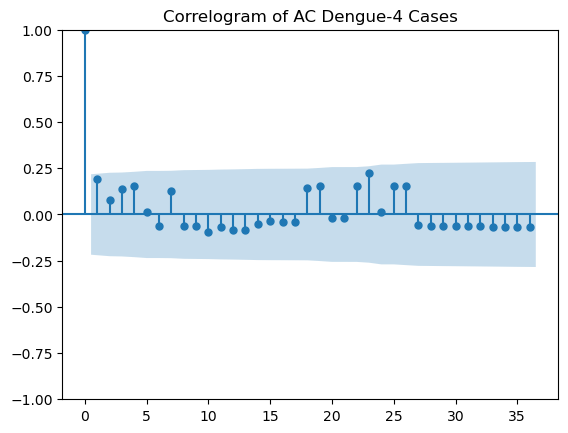

In [9]:

DENV_serotype = 4
df = Y_obs[f'p_{DENV_serotype}']
df = df.unstack(level=0)

from statsmodels.graphics.tsaplots import plot_acf

# Average over states (ignore NaNs)
national_series = df.sum(axis=1)

# Plot ACF
plot_acf(national_series.dropna(), lags=36)
plt.title(f'Correlogram of National Dengue-{DENV_serotype} Cases')
#plt.savefig(f'correlogram-BR-DENV_{DENV_serotype}.pdf')
plt.show()
plt.close()


# State-by-state plot
states_to_plot = ['SP', 'AM', 'AC']  # Pick states of interest
for state in states_to_plot:
    plt.figure()
    plot_acf(df[state].dropna(), lags=36)
    plt.title(f'Correlogram of {state} Dengue-{DENV_serotype} Cases')
    #plt.savefig(f'correlogram-{state}-DENV_{DENV_serotype}.pdf')
    plt.show()
    plt.close()
